In [22]:
import pandas as pd
import numpy as np
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

In [39]:
pip show xgboost


Name: xgboost
Version: 3.0.1
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /Users/jacobsussman/miniconda3/envs/707proj/lib/python3.12/site-packages
Requires: numpy, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [38]:
pip show scikit-learn

Name: scikit-learn
Version: 1.7.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License-Expression: BSD-3-Clause
Location: /Users/jacobsussman/miniconda3/envs/707proj/lib/python3.12/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: sentence-transformers, shap
Note: you may need to restart the kernel to use updated packages.


In [40]:
pip show shap

Name: shap
Version: 0.47.2
Summary: A unified approach to explain the output of any machine learning model.
Home-page: 
Author: 
Author-email: Scott Lundberg <slund1@cs.washington.edu>
License: MIT License
Location: /Users/jacobsussman/miniconda3/envs/707proj/lib/python3.12/site-packages
Requires: cloudpickle, numba, numpy, packaging, pandas, scikit-learn, scipy, slicer, tqdm, typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
df_pos = pd.read_csv("/Users/jacobsussman/Desktop/df_icu_true_complete.csv")
df_neg = pd.read_csv("/Users/jacobsussman/Desktop/df_icu_false_complete.csv")

df_pos["ever_icu_any_visit"] = df_pos["ever_icu_any_visit"].astype(bool)
df_neg["ever_icu_any_visit"] = df_neg["ever_icu_any_visit"].astype(bool)

df_base = pd.concat([df_pos, df_neg], ignore_index=True)

In [3]:
admission = pd.read_csv("/Users/jacobsussman/Downloads/admissions.csv")

admission["admittime"] = pd.to_datetime(admission["admittime"], errors="coerce")

admission_sorted = admission.sort_values(["subject_id", "admittime"])

admission_last = admission_sorted.groupby("subject_id").tail(1).reset_index(drop=True)

cols_to_keep = ["subject_id", "admission_type", "admission_location"] 

admission_last = admission_last[cols_to_keep]

admission_last

,subject_id,admission_type,admission_location
0,10000032,EW EMER.,EMERGENCY ROOM
1,10000068,EU OBSERVATION,EMERGENCY ROOM
2,10000084,EU OBSERVATION,PHYSICIAN REFERRAL
3,10000108,EU OBSERVATION,EMERGENCY ROOM
4,10000117,OBSERVATION ADMIT,WALK-IN/SELF REFERRAL
...,...,...,...
223447,19999733,EU OBSERVATION,EMERGENCY ROOM
223448,19999784,ELECTIVE,PHYSICIAN REFERRAL
223449,19999828,EW EMER.,TRANSFER FROM HOSPITAL
223450,19999840,EW EMER.,EMERGENCY ROOM


In [4]:
df_merged = df_base.merge(admission_last, on="subject_id", how="left")

In [5]:
emb1 = pd.read_csv("/Users/jacobsussman/Desktop/train_embeddings.csv")
emb2 = pd.read_csv("/Users/jacobsussman/Desktop/test_embeddings.csv")

emb_all = pd.concat([emb1, emb2], ignore_index=True)

In [6]:
df_final = df_merged.merge(emb_all, on="subject_id", how="left")

df_final.columns[1:30]

Index(['gender', 'anchor_age', 'anchor_year', 'anchor_year_group', 'race',
       'language', 'marital_status', 'insurance', 'n_diagnoses',
       'n_distinct_icd', 'n_hadm', 'n_transfers', 'first_intime',
       'last_outtime', 'n_icu_transfers', 'n_icu_hadm', 'ever_icu_any_visit',
       'BP_sys', 'BP_dia', 'Weight', 'n_BMI', 'n_BP', 'n_Height',
       'n_Weight_Lbs', 'Height_inches', 'admission_type', 'admission_location',
       'emb_0', 'emb_1'],
      dtype='object')

In [7]:
y = df_final["ever_icu_any_visit"].astype(int)
X = df_final.drop(columns=["ever_icu_any_visit", "subject_id", "anchor_year", "anchor_year_group", 
                           "language", "marital_status", "insurance", "n_diagnoses", "n_distinct_icd",
                          "n_transfers", "first_intime", "last_outtime", "n_icu_transfers", "n_icu_hadm",
                          "n_BMI", "n_BP", "n_Height", "n_Weight_Lbs", "Height_inches"])

# Identify categorical columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Categorical columns:", categorical_cols)

# Encode only categorical columns
X = pd.get_dummies(
    X,
    columns=categorical_cols,
    drop_first=True
)

X = X.fillna(0)

X.shape
X.columns

Categorical columns: ['gender', 'race', 'admission_type', 'admission_location']


Index(['anchor_age', 'n_hadm', 'BP_sys', 'BP_dia', 'Weight', 'emb_0', 'emb_1',
       'emb_2', 'emb_3', 'emb_4',
       ...
       'admission_location_CLINIC REFERRAL',
       'admission_location_EMERGENCY ROOM',
       'admission_location_INFORMATION NOT AVAILABLE',
       'admission_location_INTERNAL TRANSFER TO OR FROM PSYCH',
       'admission_location_PACU', 'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL'],
      dtype='object', length=440)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

In [9]:
model.ne = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist"   
)

#model.fit(X_train, y_train)

NameError: name 'XGBClassifier' is not defined

In [17]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

auroc = roc_auc_score(y_test, y_pred_proba)
auprc = average_precision_score(y_test, y_pred_proba)

print("AUROC:", auroc)
print("AUPRC:", auprc)

AUROC: 0.9523159486629904
AUPRC: 0.9333392222264869


In [10]:
embed_cols = [c for c in X_train.columns if c.startswith("emb_")]

X_train_ne = X_train.drop(columns=embed_cols)
X_test_ne  = X_test.drop(columns=embed_cols)

X_train_ne.shape, X_test_ne.shape

((77365, 56), (19342, 56))

In [34]:
model_ne.fit(X_train_ne, y_train)

NameError: name 'model_ne' is not defined

In [25]:
y_pred_proba_ne = model_ne.predict_proba(X_test_ne)[:, 1]

print("AUROC (no embeddings):", roc_auc_score(y_test, y_pred_proba_ne))
print("AUPRC (no embeddings):", average_precision_score(y_test, y_pred_proba_ne))

AUROC (no embeddings): 0.7951117509862261
AUPRC (no embeddings): 0.5800340582157705


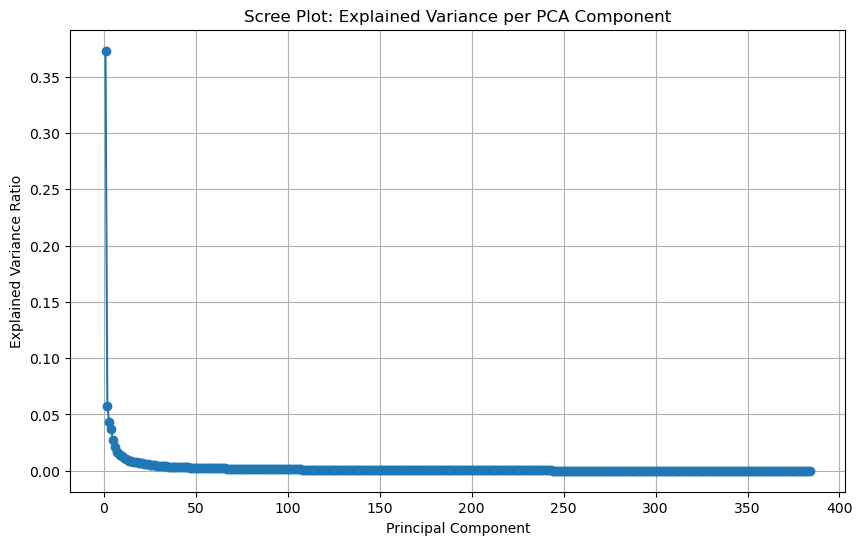

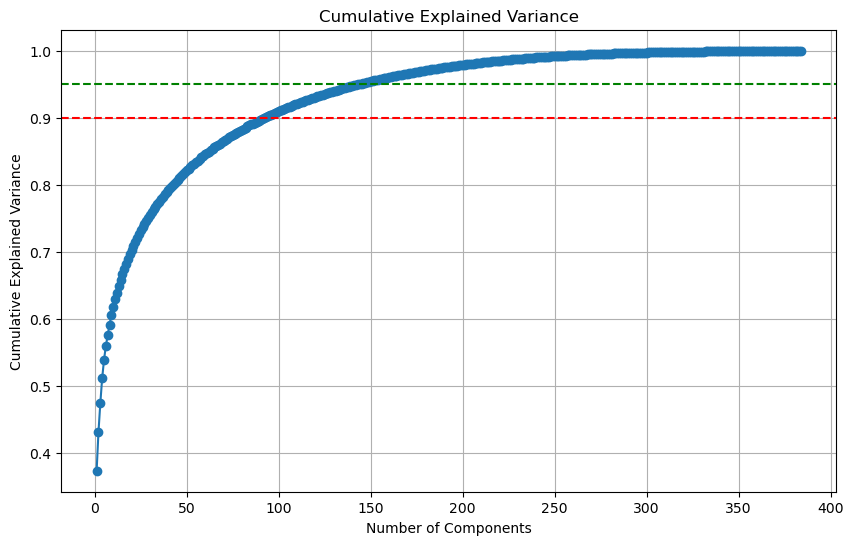

Components for 90% variance: 93
Components for 95% variance: 144


In [11]:
emb_cols = [c for c in X_train.columns if c.startswith("emb_")]
X_emb_train = X_train[emb_cols]

# fit PCA without limiting components
pca_full = PCA()
pca_full.fit(X_emb_train)

# explained variance
exp_var = pca_full.explained_variance_ratio_
cum_var = exp_var.cumsum()

# ---- Scree Plot ----
plt.figure(figsize=(10,6))
plt.plot(range(1, len(exp_var)+1), exp_var, marker='o')
plt.title("Scree Plot: Explained Variance per PCA Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

# ---- Cumulative Variance Plot ----
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--')  # 90% line
plt.axhline(y=0.95, color='g', linestyle='--')  # 95% line
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

print(f"Components for 90% variance: {(cum_var < 0.90).sum() + 1}")
print(f"Components for 95% variance: {(cum_var < 0.95).sum() + 1}")

In [12]:
emb_cols = [c for c in X_train.columns if c.startswith("emb_")]
non_emb_cols = [c for c in X_train.columns if not c.startswith("emb_")]

In [13]:
pca = PCA(n_components=45)
pca.fit(X_train[emb_cols])

X_train_pca = pca.transform(X_train[emb_cols])
X_test_pca  = pca.transform(X_test[emb_cols])

In [14]:
pca_cols = [f"pca_emb_{i}" for i in range(X_train_pca.shape[1])]

X_train_embed_model = pd.concat(
    [
        X_train[non_emb_cols].reset_index(drop=True),
        pd.DataFrame(X_train_pca, columns=pca_cols)
    ],
    axis=1
)

X_test_embed_model = pd.concat(
    [
        X_test[non_emb_cols].reset_index(drop=True),
        pd.DataFrame(X_test_pca, columns=pca_cols)
    ],
    axis=1
)

In [15]:
model_emb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist"   
)

model_emb.fit(X_train_embed_model, y_train)

NameError: name 'XGBClassifier' is not defined

In [33]:
preds = model_emb.predict_proba(X_test_embed_model)[:,1]

auroc = roc_auc_score(y_test, preds)
auprc = average_precision_score(y_test, preds)

print("AUROC:", auroc)
print("AUPRC:", auprc)

AUROC: 0.9520869092161468
AUPRC: 0.9330796504657677


In [ ]:
y_pred_baseline = model_noemb.predict_proba(X_test_ne)[:,1]
y_pred_embed    = model_emb.predict_proba(X_test_embed_model)[:,1]

# ROC curves
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_baseline)
fpr_emb, tpr_emb, _   = roc_curve(y_test, y_pred_embed)

plt.figure(figsize=(6,6))
plt.plot(fpr_base, tpr_base, label=f"Baseline (AUROC={roc_auc_score(y_test, y_pred_baseline):.3f})")
plt.plot(fpr_emb, tpr_emb, label=f"PCA Embeddings (AUROC={roc_auc_score(y_test, y_pred_embed):.3f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [40]:
X_train_embed_model

,anchor_age,n_hadm,BP_sys,BP_dia,Weight,gender_M,race_ASIAN,race_ASIAN - ASIAN INDIAN,race_ASIAN - CHINESE,race_ASIAN - KOREAN,...,pca_emb_35,pca_emb_36,pca_emb_37,pca_emb_38,pca_emb_39,pca_emb_40,pca_emb_41,pca_emb_42,pca_emb_43,pca_emb_44
0,69,9,103,75,150.00,False,False,False,False,False,...,-0.000185,0.000366,-0.000269,-0.000178,0.000188,-0.000015,-0.000075,0.000030,0.000054,0.000078
1,74,20,122,56,124.78,True,False,False,False,False,...,0.116164,-0.014108,0.062439,-0.063445,-0.100856,-0.032026,0.176299,0.125619,0.198780,0.042597
2,89,2,130,60,126.00,False,False,False,False,False,...,-0.000185,0.000366,-0.000269,-0.000178,0.000188,-0.000015,-0.000075,0.000030,0.000054,0.000078
3,32,1,170,102,185.00,False,True,False,False,False,...,-0.000185,0.000366,-0.000269,-0.000178,0.000188,-0.000015,-0.000075,0.000030,0.000054,0.000078
4,34,2,130,80,288.70,True,False,False,False,False,...,-0.000185,0.000366,-0.000269,-0.000178,0.000188,-0.000015,-0.000075,0.000030,0.000054,0.000078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77360,61,2,110,60,108.00,False,False,False,False,False,...,0.091276,0.031607,-0.033243,-0.025636,-0.044266,-0.029456,0.183537,-0.019776,-0.048078,-0.110695
77361,30,5,138,68,161.50,False,False,False,False,False,...,-0.000185,0.000366,-0.000269,-0.000178,0.000188,-0.000015,-0.000075,0.000030,0.000054,0.000078
77362,87,2,180,96,93.00,False,False,False,False,False,...,-0.000185,0.000366,-0.000269,-0.000178,0.000188,-0.000015,-0.000075,0.000030,0.000054,0.000078
77363,54,10,94,58,136.00,False,False,False,False,False,...,0.044656,0.216135,-0.117553,0.025623,0.217065,-0.083381,-0.078546,-0.168229,-0.143094,-0.043766


In [16]:
def cross_validate_xgb(X, y, n_splits=5, params=None, n_estimators=200):
    y_array = y.to_numpy() if hasattr(y, "to_numpy") else np.array(y)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    aurocs = []
    auprcs = []
    models = []
    
    for train_idx, val_idx in kf.split(X, y_array):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y_array[train_idx], y_array[val_idx]
        
        model = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=params.get("max_depth",3),
            learning_rate=params.get("learning_rate",0.1),
            subsample=params.get("subsample",0.8),
            colsample_bytree=params.get("colsample_bytree",0.8),
            tree_method=params.get("tree_method","hist"),
            eval_metric="auc",
            objective="binary:logistic",
            use_label_encoder=False
        )
        
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict_proba(X_val)[:,1]
        aurocs.append(roc_auc_score(y_val, y_val_pred))
        auprcs.append(average_precision_score(y_val, y_val_pred))
        models.append(model)
    
    return aurocs, auprcs, models


In [17]:
xgb_params = {
    "max_depth": 3,
    "learning_rate": 0.05,
    "subsample": 0.7,
    "colsample_bytree": 0.9,
    "tree_method": "hist"
}


In [18]:
final_model_base = xgb.XGBClassifier(**xgb_params, n_estimators=300)
final_model_base.fit(X_train_ne, y_train)

final_model_embed = xgb.XGBClassifier(**xgb_params, n_estimators=300)
final_model_embed.fit(X_train_embed_model, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


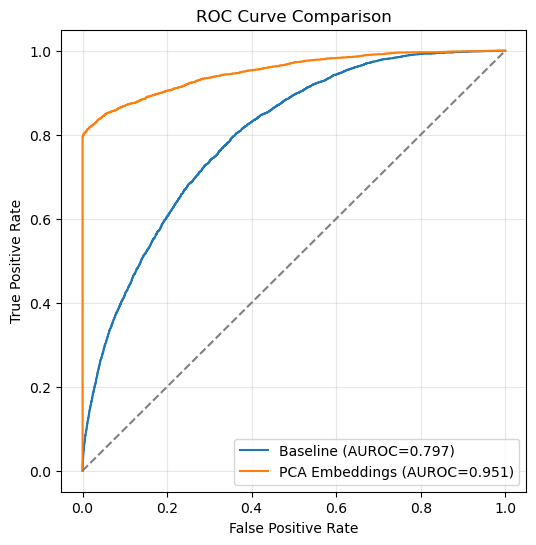

In [19]:
y_pred_base = final_model_base.predict_proba(X_test_ne)[:,1]
y_pred_embed = final_model_embed.predict_proba(X_test_embed_model)[:,1]

fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_base)
fpr_embed, tpr_embed, _ = roc_curve(y_test, y_pred_embed)

plt.figure(figsize=(6,6))
plt.plot(fpr_base, tpr_base, label=f"Baseline (AUROC={roc_auc_score(y_test, y_pred_base):.3f})")
plt.plot(fpr_embed, tpr_embed, label=f"PCA Embeddings (AUROC={roc_auc_score(y_test, y_pred_embed):.3f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [54]:
auroc_base, auprc_base, models_base = cross_validate_xgb(X_train_ne, y_train, n_splits=5, params=xgb_params)

print("Baseline model CV AUROC: %.3f ± %.3f" % (np.mean(auroc_base), np.std(auroc_base)))
print("Baseline model CV AUPRC: %.3f ± %.3f" % (np.mean(auprc_base), np.std(auprc_base)))


/Users/jacobsussman/miniconda3/envs/707proj/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:32:06] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jacobsussman/miniconda3/envs/707proj/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:32:06] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jacobsussman/miniconda3/envs/707proj/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:32:07] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not u

Baseline model CV AUROC: 0.794 ± 0.001
Baseline model CV AUPRC: 0.581 ± 0.003


In [55]:
auroc_embed, auprc_embed, models_embed = cross_validate_xgb(X_train_embed_model, y_train, n_splits=5, params=xgb_params)

print("Embedding model CV AUROC: %.3f ± %.3f" % (np.mean(auroc_embed), np.std(auroc_embed)))
print("Embedding model CV AUPRC: %.3f ± %.3f" % (np.mean(auprc_embed), np.std(auprc_embed)))


/Users/jacobsussman/miniconda3/envs/707proj/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:32:24] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jacobsussman/miniconda3/envs/707proj/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:32:24] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jacobsussman/miniconda3/envs/707proj/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:32:25] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not u

Embedding model CV AUROC: 0.949 ± 0.002
Embedding model CV AUPRC: 0.929 ± 0.002


In [56]:
final_model_base = xgb.XGBClassifier(**xgb_params, n_estimators=300)
final_model_base.fit(X_train_ne, y_train)

final_model_embed = xgb.XGBClassifier(**xgb_params, n_estimators=300)
final_model_embed.fit(X_train_embed_model, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


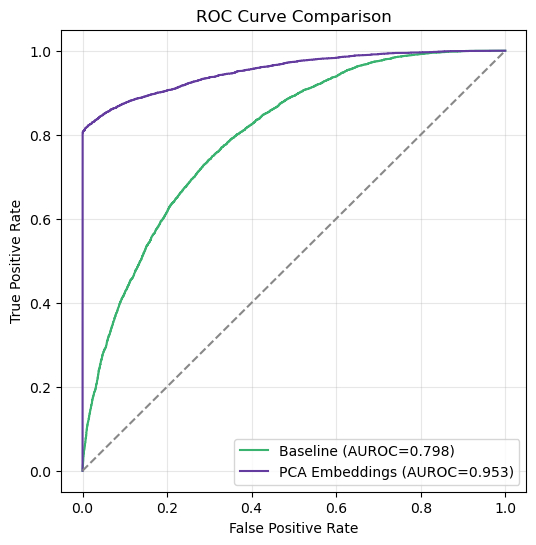

In [61]:

y_pred_base  = final_model_base.predict_proba(X_test_ne)[:,1]
y_pred_embed = final_model_embed.predict_proba(X_test_embed_model)[:,1]

fpr_base, tpr_base, _   = roc_curve(y_test, y_pred_base)
fpr_embed, tpr_embed, _ = roc_curve(y_test, y_pred_embed)

color_base  = "#3ab270" 
color_embed = "#643b9f"  

plt.figure(figsize=(6,6))
plt.plot(fpr_base, tpr_base, color=color_base, label=f"Baseline (AUROC={roc_auc_score(y_test, y_pred_base):.3f})")
plt.plot(fpr_embed, tpr_embed, color=color_embed, label=f"PCA Embeddings (AUROC={roc_auc_score(y_test, y_pred_embed):.3f})")
plt.plot([0,1],[0,1], linestyle="--", color="#888888")  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


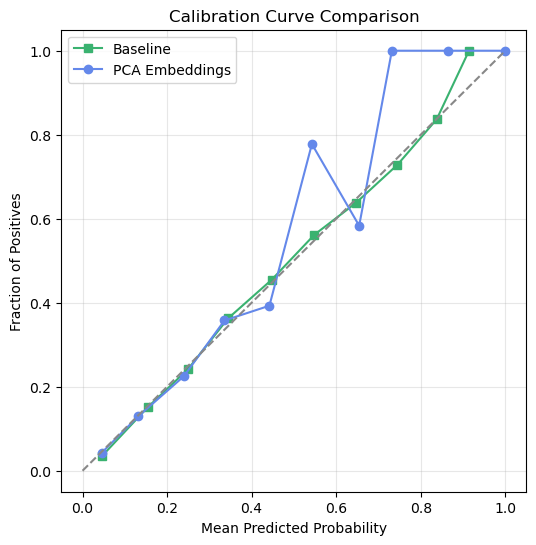

In [70]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

frac_base, mean_base   = calibration_curve(y_test, y_pred_base, n_bins=10)
frac_embed, mean_embed = calibration_curve(y_test, y_pred_embed, n_bins=10)

color_base  = "#3ab270"  
color_embed = "#6488ea"  
diag_color  = "#888888"  

plt.figure(figsize=(6,6))
plt.plot(mean_base, frac_base, "s-", color=color_base, label="Baseline")
plt.plot(mean_embed, frac_embed, "o-", color=color_embed, label="PCA Embeddings")
plt.plot([0,1],[0,1], linestyle="--", color=diag_color)  
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



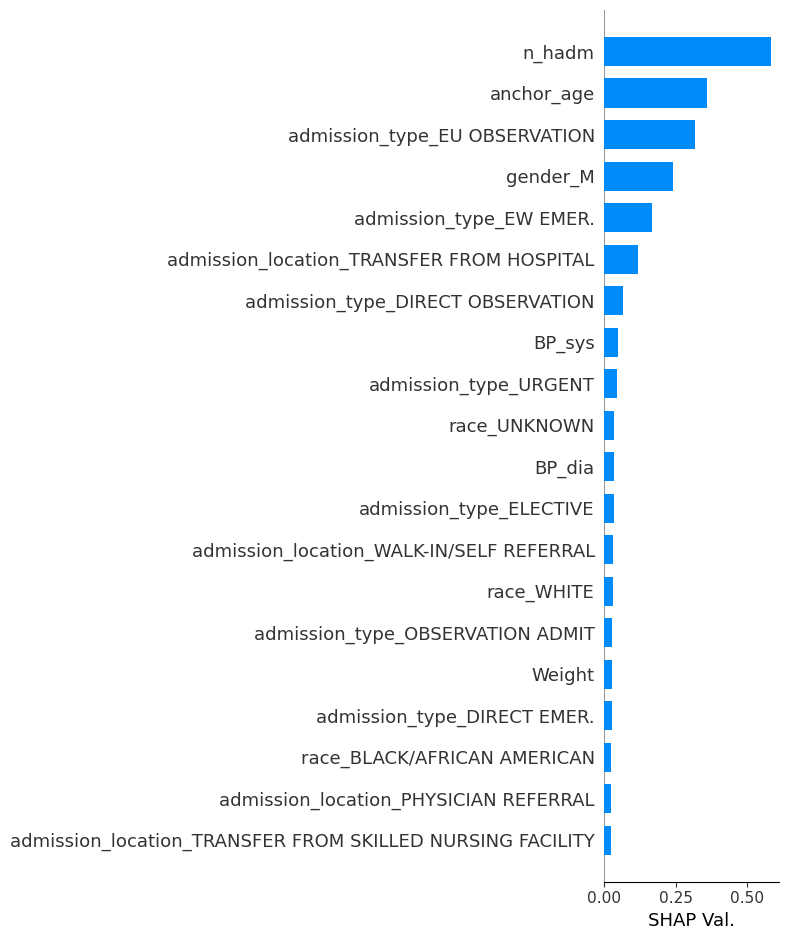

In [77]:

explainer_base = shap.TreeExplainer(final_model_base)
shap_values_base = explainer_base.shap_values(X_test_ne)

shap.summary_plot(shap_values_base, X_test_ne, plot_type="bar", max_display=20, show=False)

plt.xlabel("SHAP Val.")
plt.show()



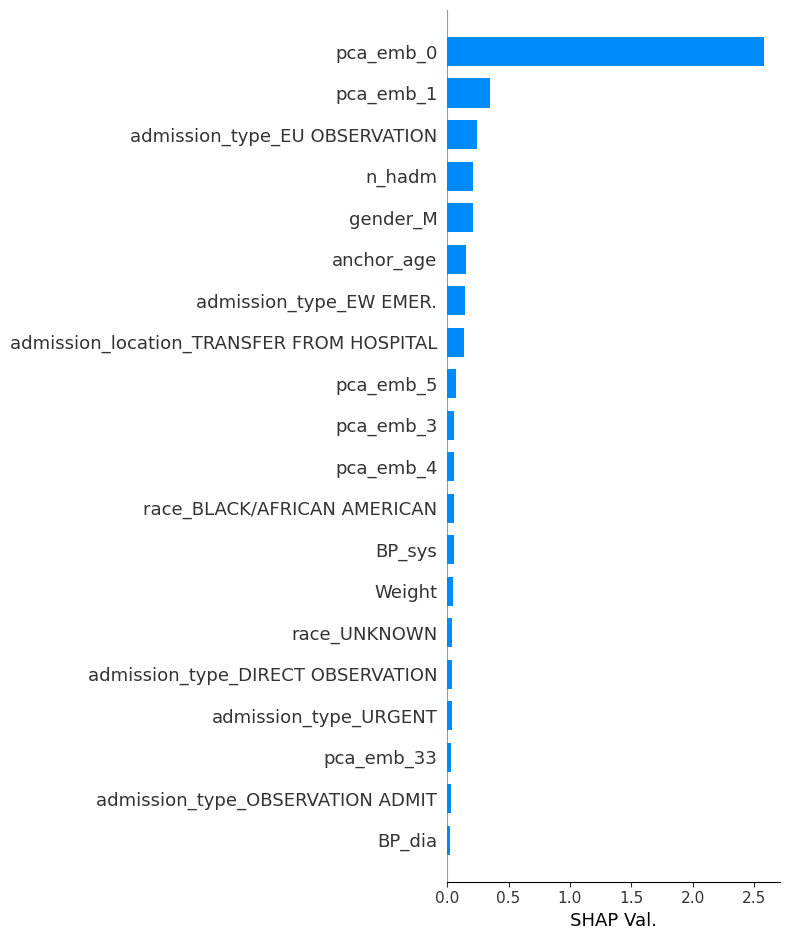

In [78]:
explainer_embed = shap.TreeExplainer(final_model_embed)
shap_values_embed = explainer_embed.shap_values(X_test_embed_model)

shap.summary_plot(shap_values_embed, X_test_embed_model, plot_type="bar", max_display=20, show=False)

plt.xlabel("SHAP Val.")
plt.show()

In [79]:
y_pred_base  = final_model_base.predict_proba(X_test_ne)[:,1]
y_pred_embed = final_model_embed.predict_proba(X_test_embed_model)[:,1]

# Brier scores
brier_base  = brier_score_loss(y_test, y_pred_base)
brier_embed = brier_score_loss(y_test, y_pred_embed)

print(f"Baseline model Brier score: {brier_base:.4f}")
print(f"Embedding model Brier score: {brier_embed:.4f}")

Baseline model Brier score: 0.1540
Embedding model Brier score: 0.0463


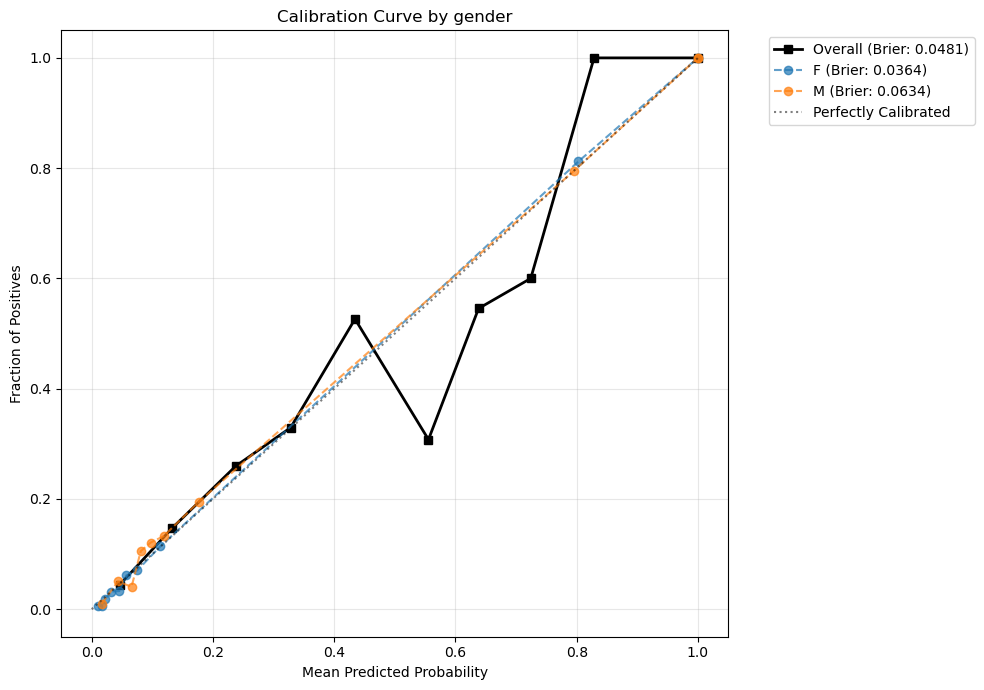

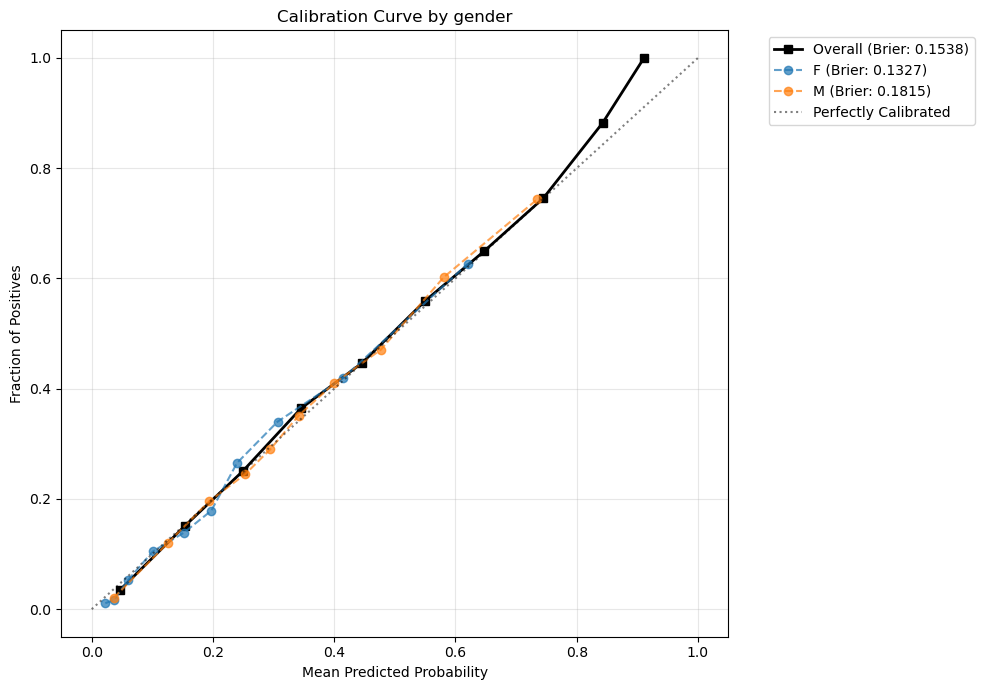

In [32]:
df_test_meta = df_final.loc[X_test.index].reset_index(drop=True)
y_test_aligned = y_test.reset_index(drop=True)

def plot_calibration_by_subgroup(model, X_data, y_true, df_meta, subgroup_col, n_bins=10):

    plt.figure(figsize=(10, 7))

    probs = model.predict_proba(X_data)[:, 1]
    
    prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=n_bins)
    brier = brier_score_loss(y_true, probs)
    plt.plot(prob_pred, prob_true, "s-", color="black", linewidth=2, 
             label=f"Overall (Brier: {brier:.4f})")

    subgroups = df_meta[subgroup_col].unique()
    
    for group in subgroups:
        mask = df_meta[subgroup_col] == group
        
        if mask.sum() < 50:
            continue
            
        y_sub = y_true[mask]
        probs_sub = probs[mask]
        
        prob_true_sub, prob_pred_sub = calibration_curve(y_sub, probs_sub, n_bins=n_bins, strategy='quantile')
        brier_sub = brier_score_loss(y_sub, probs_sub)
        
        plt.plot(prob_pred_sub, prob_true_sub, "o--", alpha=0.7, 
                 label=f"{group} (Brier: {brier_sub:.4f})")
        
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated", alpha=0.5)
    
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title(f"Calibration Curve by {subgroup_col}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_calibration_by_subgroup(
    final_model_embed, 
    X_test_embed_model, 
    y_test_aligned, 
    df_test_meta, 
    "gender"
)


plot_calibration_by_subgroup(
    final_model_base, 
    X_test_ne, 
    y_test_aligned, 
    df_test_meta, 
    "gender"
)

In [28]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def get_optimal_f1_threshold(y_true, y_probs):

    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

    numerator = 2 * precision * recall
    denominator = precision + recall
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)

    ix = np.argmax(f1_scores)

    if ix < len(thresholds):
        best_thresh = thresholds[ix]
    else:
        best_thresh = 1.0 
        
    return best_thresh, f1_scores[ix]

thresh_base, f1_base = get_optimal_f1_threshold(y_test, probs_base)
thresh_embed, f1_embed = get_optimal_f1_threshold(y_test, probs_embed)

print(f"Optimal Threshold (Baseline):  {thresh_base:.4f} (Max F1: {f1_base:.4f})")
print(f"Optimal Threshold (Embedding): {thresh_embed:.4f} (Max F1: {f1_embed:.4f})")
print("-" * 60)


metrics_base_opt = get_complete_metrics(y_test, probs_base, threshold=thresh_base)
metrics_embed_opt = get_complete_metrics(y_test, probs_embed, threshold=thresh_embed)

df_metrics_opt = pd.DataFrame([metrics_base_opt, metrics_embed_opt], 
                              index=["Baseline (Opt Thresh)", "Embedding (Opt Thresh)"])

df_display_opt = df_metrics_opt.T

print("=== Classification Metrics Comparison (Maximized F1 Threshold) ===")
display(df_display_opt)

Optimal Threshold (Baseline):  0.2849 (Max F1: 0.5807)
Optimal Threshold (Embedding): 0.6095 (Max F1: 0.8865)
------------------------------------------------------------
=== Classification Metrics Comparison (Maximized F1 Threshold) ===


,Baseline (Opt Thresh),Embedding (Opt Thresh)
AUROC,0.797039,0.951157
Accuracy,0.716110,0.944577
Sensitivity (Recall),0.724519,0.797295
Specificity,0.712978,0.999432
PPV (Precision),0.484582,0.998092
NPV,0.874195,0.929764
F1 Score,0.580744,0.886465
True Positives,3803.000000,4185.000000
False Positives,4045.000000,8.000000
True Negatives,10048.000000,14085.000000


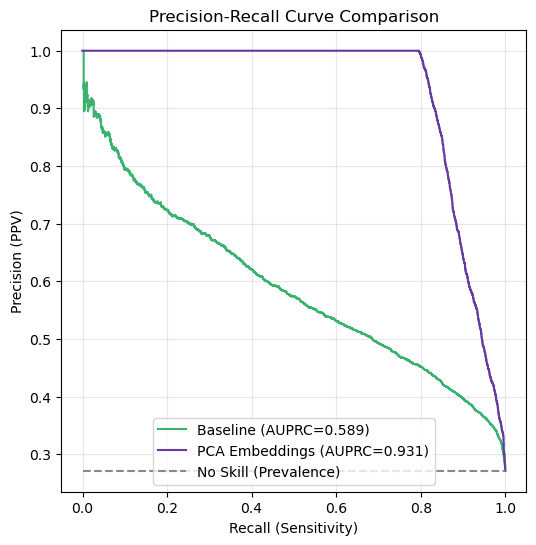

In [31]:
y_pred_base  = final_model_base.predict_proba(X_test_ne)[:,1]
y_pred_embed = final_model_embed.predict_proba(X_test_embed_model)[:,1]

prec_base, recall_base, _   = precision_recall_curve(y_test, y_pred_base)
prec_embed, recall_embed, _ = precision_recall_curve(y_test, y_pred_embed)

auprc_base  = average_precision_score(y_test, y_pred_base)
auprc_embed = average_precision_score(y_test, y_pred_embed)

no_skill = y_test.sum() / len(y_test)

color_base  = "#3ab270" 
color_embed = "#643b9f" 

plt.figure(figsize=(6,6))
plt.plot(recall_base, prec_base, color=color_base, label=f"Baseline (AUPRC={auprc_base:.3f})")
plt.plot(recall_embed, prec_embed, color=color_embed, label=f"PCA Embeddings (AUPRC={auprc_embed:.3f})")

plt.plot([0, 1], [no_skill, no_skill], linestyle="--", color="#888888", label="No Skill (Prevalence)")

plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (PPV)")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.show()